In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import evaluate

from rouge_score import rouge_scorer
import seaborn as sns

In [13]:
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('expand_frame_repr', True)

In [14]:
mapping = {
# "Qwen2-VL":r"C:\Users\moham\Desktop\SwarmChat_github\SwarmChat\prompt_engineering\First step\resultes\Bad Qwen2-VL-7B-Instruct-Q4_K_M_log.csv",
"CodeLlama-7b":r"C:\Users\moham\Desktop\SwarmChat_github\SwarmChat\prompt_engineering\First step\resultes\CodeLlama-7b-hf-Q4_K_M_log.csv",
# "deepseek-coder-instruct-1.3b":r"C:\Users\moham\Desktop\SwarmChat_github\SwarmChat\prompt_engineering\First step\resultes\deepseek-coder-1.3b-instruct.Q4_K_M_log.csv",
"deepseek-coder-instruct-6.7b":r"C:\Users\moham\Desktop\SwarmChat_github\SwarmChat\prompt_engineering\First step\resultes\deepseek-coder-6.7b-instruct.Q4_K_M_log.csv",
"deepseek-coder-base-7b":r"C:\Users\moham\Desktop\SwarmChat_github\SwarmChat\prompt_engineering\First step\resultes\deepseek-coder-7b-base-v1.5.Q4_K_M_log.csv",
"DeepSeek-R1-Distill-llama-8B":r"C:\Users\moham\Desktop\SwarmChat_github\SwarmChat\prompt_engineering\First step\resultes\DeepSeek-R1-Distill-llama-8B-Q4_K_M_log.csv",
# "DeepSeek-R1-Distill-Qwen-14B":r"C:\Users\moham\Desktop\SwarmChat_github\SwarmChat\prompt_engineering\First step\resultes\DeepSeek-R1-Distill-Qwen-14B-Q4_K_M_log.csv",
"DeepSeek-R1-Distill-Qwen-7B":r"C:\Users\moham\Desktop\SwarmChat_github\SwarmChat\prompt_engineering\First step\resultes\DeepSeek-R1-Distill-Qwen-7B-Q4_K_M_log.csv",
# "EuroLLM-instruct-1.7b":r"C:\Users\moham\Desktop\SwarmChat_github\SwarmChat\prompt_engineering\First step\resultes\eurollm-1.7b-instruct-q4_k_m_log.csv",
"EuroLLM-Instruct-9B":r"C:\Users\moham\Desktop\SwarmChat_github\SwarmChat\prompt_engineering\First step\resultes\EuroLLM-9B-Instruct-Q4_K_M_log.csv",
"Falcon3-Instruct-10B":r"C:\Users\moham\Desktop\SwarmChat_github\SwarmChat\prompt_engineering\First step\resultes\Falcon3-10B-Instruct-q4_k_m_log.csv",
# "Falcon3-Instruct-7B":r"C:\Users\moham\Desktop\SwarmChat_github\SwarmChat\prompt_engineering\First step\resultes\Falcon3-7B-Instruct-q4_k_m_log.csv",
"Meta-Llama-Instruct-3.1-8B":r"C:\Users\moham\Desktop\SwarmChat_github\SwarmChat\prompt_engineering\First step\resultes\Meta-Llama-3.1-8B-Instruct-Q4_K_M_log.csv",
"Mistral-7B":r"C:\Users\moham\Desktop\SwarmChat_github\SwarmChat\prompt_engineering\First step\resultes\Mistral-7B-Instruct-v0.3.Q4_K_M_log.csv",
"phi-4-14B":r"C:\Users\moham\Desktop\SwarmChat_github\SwarmChat\prompt_engineering\First step\resultes\phi-4-Q4_K_M_log.csv",
"Qwen2.5-Coder-Instruct-7B":r"C:\Users\moham\Desktop\SwarmChat_github\SwarmChat\prompt_engineering\First step\resultes\Qwen2.5-Coder-7B-Instruct-Q4_K_M_log.csv"
}


dfs = []
for model, file_path in mapping.items():
    temp_df = pd.read_csv(file_path, encoding='utf-8')
    temp_df["Model Name"] = model
    temp_df['Behavior Tree'] = temp_df['Behavior Tree'].astype(str).str.replace(r'\n|\t', ' ', regex=True)

    dfs.append(temp_df)

# Concatenate all DataFrames into one final DataFrame
final_df = pd.concat(dfs, ignore_index=True)


Ground_Truth_df= pd.read_csv(r"C:\Users\moham\Desktop\SwarmChat_github\SwarmChat\prompt_engineering\First step\ex_ground_truth.csv")
Ground_Truth_df['Behavior Tree']= Ground_Truth_df['Behavior Tree'].str.replace(r'\n|\t', ' ', regex=True)

final_df.head(2)
Ground_Truth_df.head(2)

,Prompt,Behavior Tree
0,"detect an obstacle, avoid it, and then flock safely with other agents","<root BTCPP_format=""3"" main_tree_to_execute=""ObstacleAvoidanceAndFlocking""> <BehaviorTree ID=""ObstacleAvoidanceAndFlocking""> <Sequence name=""Detect and Avoid Obstacle Then Flock""> <is_obstacle_detected/> <avoid_obstacle/> <change_color color=""green""/> </Sequence> </BehaviorTree> <TreeNodesModel> <Condition ID=""is_obstacle_detected""/> <Action ID=""avoid_obstacle""/> <Action ID=""change_color"" editable=""true""> <input_port name=""color""/> </Action> </TreeNodesModel> </root>"
1,"wander randomly until a target is detected, approach it, and signal achievement by changing color to red","<root BTCPP_format=""3"" main_tree_to_execute=""WanderApproachAndSignal""> <BehaviorTree ID=""WanderApproachAndSignal""> <Sequence name=""Wander, Approach, and Signal""> <Fallback name=""DetectTargetOrWander""> <Sequence name=""TargetDetectedAndReached""> <is_target_detected/> <is_target_reached/> <change_color color=""red""/> </Sequence> </Fallback> <wander/> </Sequence> </BehaviorTree> <TreeNodesModel> <Condition ID=""is_target_detected""/> <Condition ID=""is_target_reached""/> <Action ID=""wander""/> <Action ID=""change_color"" editable=""true""> <input_port name=""color""/> </Action> </TreeNodesModel> </root>"


In [15]:
# Load the evaluation metrics:
bleu_metric = evaluate.load("bleu", config_name="bleu")
rouge_metric = evaluate.load("rouge")
meteor_metric = evaluate.load("meteor")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [16]:
import pandas as pd

# Add empty evaluation columns for the metrics
final_df["bleu_score"] = None
final_df["rouge_score"] = None
final_df["meteor_score"] = None


# Loop over each ground truth row and each row in final_df
for gt_index, gt_row in Ground_Truth_df.iterrows():
    for idx, row in final_df.iterrows():
        # Compare the "Prompt" in the ground truth with the "Prompt" in final_df
        if gt_row["Prompt"] == row["Prompt"]:
            # Check if either the generated or ground truth behavior tree is missing.
            if pd.isna(row["Behavior Tree"]) or pd.isna(gt_row["Behavior Tree"]):
                print(f"Skipping row {idx} due to missing Behavior Tree.")
                continue  # Skip if either value is NaN
            
            # Wrap the values in lists for the evaluation functions.
            # prediction: list with one string; reference: list containing one list of one string.
            prediction = [row["Behavior Tree"]]
            reference = [[gt_row["Behavior Tree"]]]
            
            # # Optionally, print their lengths for debugging:
            # print("Length of prediction string:", len(prediction[0]))
            # print("Length of reference string:", len(reference[0][0]))
            
            # Compute evaluation metrics using the evaluate module.
            bleu_score = bleu_metric.compute(predictions=prediction, references=reference)["bleu"]
            rouge_score = rouge_metric.compute(predictions=prediction, references=reference)["rougeL"]
            meteor_score = meteor_metric.compute(predictions=prediction, references=reference)["meteor"]
            
            # Save the computed scores into final_df for this row.
            final_df.loc[idx, "bleu_score"] = bleu_score
            final_df.loc[idx, "rouge_score"] = rouge_score
            final_df.loc[idx, "meteor_score"] = meteor_score

final_df.replace([None], 0, inplace=True)

C:\Users\moham\AppData\Local\Temp\ipykernel_21572\2755578450.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df.replace([None], 0, inplace=True)


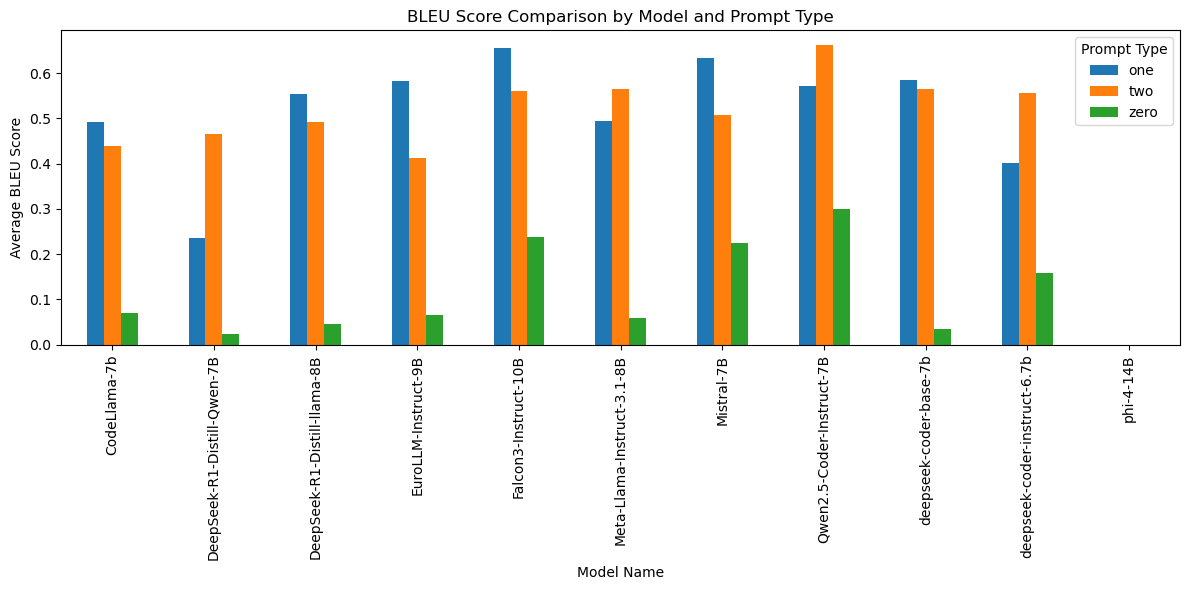

In [17]:
# Create a pivot table that computes (for example) the average BLEU score for each model and prompt type.
# You can replace .mean() with a different aggregation (e.g., .max(), .median()) if needed.
pivot_bleu = final_df.groupby(["Model Name", "Prompt Type"])["bleu_score"].mean().unstack()

# Plot the pivot table; each model on the x-axis with bars for each Prompt Type.
pivot_bleu.plot(kind="bar", figsize=(12, 6))

plt.xlabel("Model Name")
plt.ylabel("Average BLEU Score")
plt.title("BLEU Score Comparison by Model and Prompt Type")
plt.legend(title="Prompt Type")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


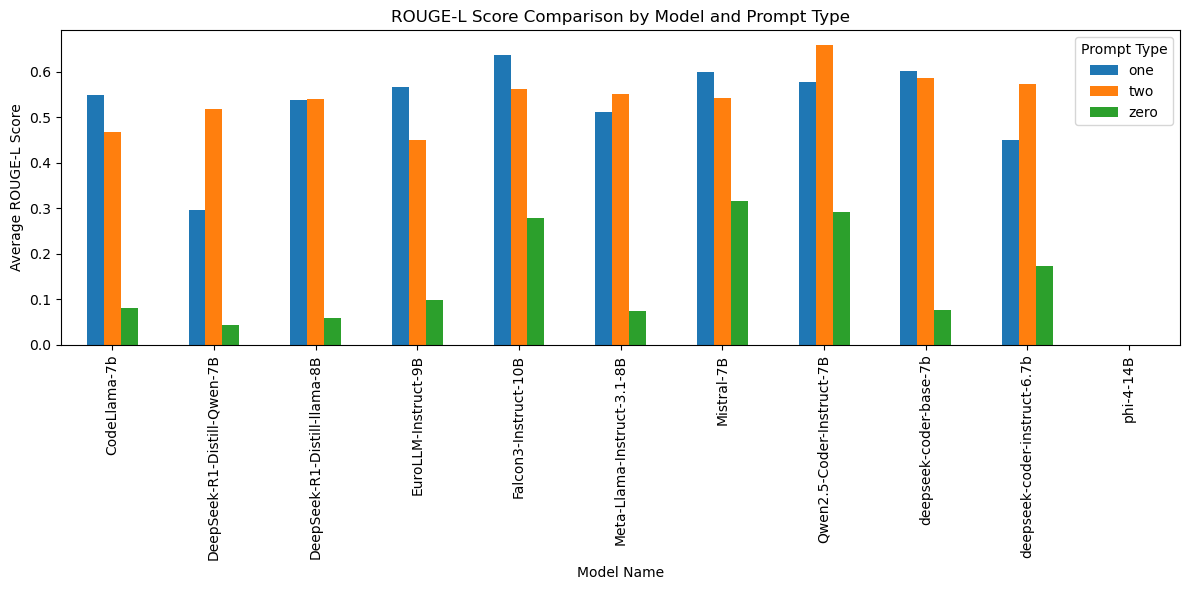

In [18]:
# Create a pivot table for the average ROUGE-L score for each model and prompt type.
pivot_rouge = final_df.groupby(["Model Name", "Prompt Type"])["rouge_score"].mean().unstack()

# Plot the pivot table; each model on the x-axis with bars for each Prompt Type.
pivot_rouge.plot(kind="bar", figsize=(12, 6))

plt.xlabel("Model Name")
plt.ylabel("Average ROUGE-L Score")
plt.title("ROUGE-L Score Comparison by Model and Prompt Type")
plt.legend(title="Prompt Type")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


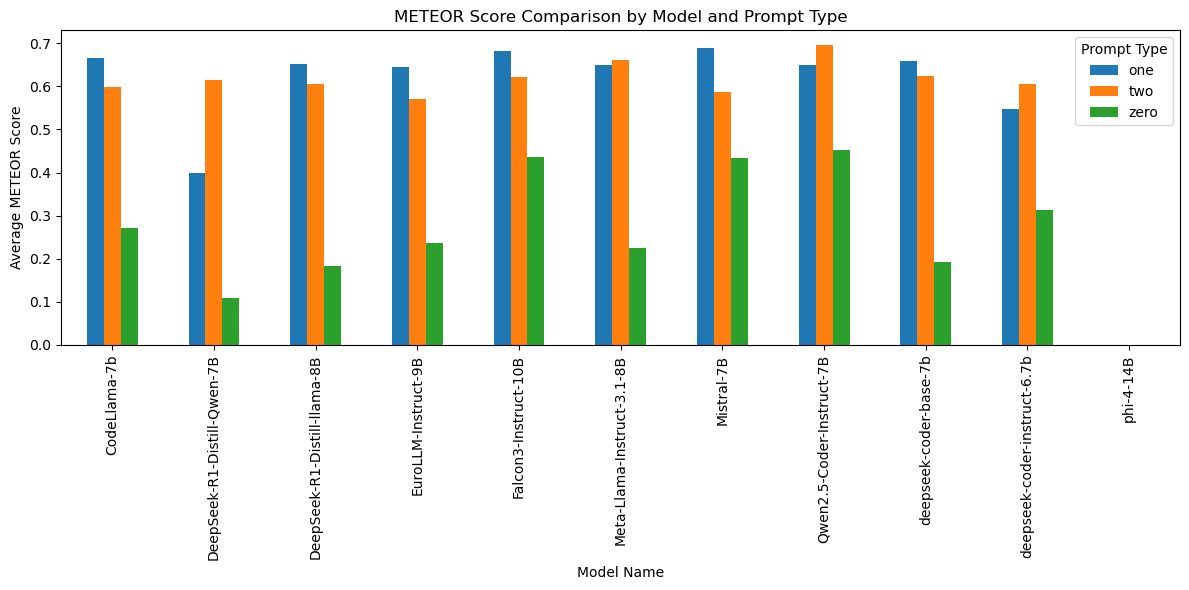

In [19]:
# Create a pivot table for the average METEOR score for each model and prompt type.
pivot_meteor = final_df.groupby(["Model Name", "Prompt Type"])["meteor_score"].mean().unstack()

# Plot the pivot table; each model on the x-axis with bars for each Prompt Type.
pivot_meteor.plot(kind="bar", figsize=(12, 6))

plt.xlabel("Model Name")
plt.ylabel("Average METEOR Score")
plt.title("METEOR Score Comparison by Model and Prompt Type")
plt.legend(title="Prompt Type")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [20]:
import pandas as pd
import xml.etree.ElementTree as ET



# Allowed tags for node content
allowed_node_tags = { "say",
"flocking",
"align_with_swarm",
"is_obstacle_detected",
"avoid_obstacle",
"is_target_detected",
"is_target_reached",
"change_color",
"is_agent_in_nest",
"agent_movement_freeze",
"continue_movement_agent",
"wander",
"is_path_clear",
"is_line_formed",
"form_line",
"indicating",
"move_randomly"}

# Structural wrappers that we do not check against allowed_node_tags
structural_tags = {"root", "BehaviorTree", "TreeNodesModel",
                   "Sequence", "Fallback", "Action", "Condition","input_port",}

def check_xml_syntax(xml_str):
    errors = []

    # Ensure the input is a string.
    if not isinstance(xml_str, str):
        errors.append("XML data is not a string.")
        return errors

    # Check that XML starts with <root ...> and ends with </root>
    stripped = xml_str.strip()
    if not stripped.startswith("<root"):
        errors.append("XML does not start with <root> tag.")
    if not stripped.endswith("</root>"):
        errors.append("XML does not end with </root> tag.")

    # Try parsing the XML
    try:
        root = ET.fromstring(xml_str)
    except ET.ParseError as e:
        errors.append(f"XML parsing error: {e}")
        return errors  # If XML is not well-formed, stop further checking.

    # Check that root tag is "root"
    if root.tag != "root":
        errors.append(f"Root tag is '{root.tag}' instead of 'root'.")

    # Check for main_tree_to_execute attribute on the root element
    main_tree = root.attrib.get("main_tree_to_execute")
    if main_tree is None:
        errors.append("Attribute 'main_tree_to_execute' not found in <root> element.")
    else:
        # Check that there is a BehaviorTree element with an ID matching main_tree_to_execute.
        behavior_trees = root.findall("BehaviorTree")
        bt_found = any(bt.attrib.get("ID") == main_tree for bt in behavior_trees)
        if not bt_found:
            errors.append("No <BehaviorTree> element with ID matching 'main_tree_to_execute' found.")

    # Check for the existence of the <TreeNodesModel> element.
    tn_model = root.find("TreeNodesModel")
    if tn_model is None:
        errors.append("No <TreeNodesModel> element found.")

    # Recursively check for allowed tags in the XML (skip structural wrappers)
    for elem in root.iter():
        if elem.tag in structural_tags:
            continue
        if elem.tag not in allowed_node_tags:
            errors.append(f"Disallowed element tag found: '{elem.tag}'.")

    return errors

def check_all_xml_rows(df, xml_column="Behavior Tree"):
    results = []
    for idx, row in df.iterrows():
        xml_value = row[xml_column]
        errors = check_xml_syntax(xml_value)
        results.append(errors)
    return results

# Helper function to safely parse and extract main_tree_to_execute attribute from XML.
def safe_parse_main_tree(xml_str):
    # Check if the value is a string. If not, return None.
    if not isinstance(xml_str, str):
        return None
    try:
        root = ET.fromstring(xml_str)
        return root.attrib.get("main_tree_to_execute")
    except ET.ParseError:
        return None



df = pd.DataFrame(final_df)

# Apply the syntax check over the DataFrame.
df["Syntax_Errors"] = check_all_xml_rows(df, xml_column="Behavior Tree")
# print(df["Syntax_Errors"])

# Create a new column with the main_tree attribute (safely parsed)
df["MainTree"] = df["Behavior Tree"].apply(safe_parse_main_tree)






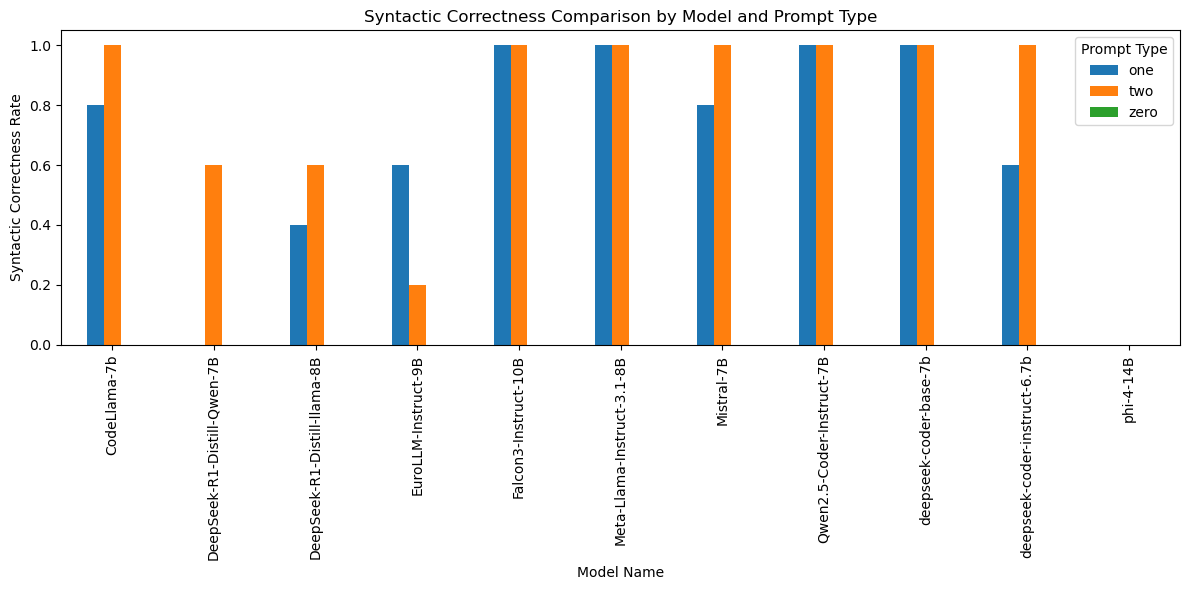

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a boolean column: True if XML is syntactically correct (i.e. Syntax_Errors is empty)
df["syntax_correct"] = df["Syntax_Errors"].apply(lambda errors: len(errors) == 0)


# --- Create a pivot table for the average syntactic correctness rate (0 to 1) ---
# The average of True/False values (with True = 1, False = 0) gives the proportion of correct entries.
pivot_syntax = df.groupby(["Model Name", "Prompt Type"])["syntax_correct"].mean().unstack()

# Plot the pivot table; each model on the x-axis with bars for each Prompt Type.
pivot_syntax.plot(kind="bar", figsize=(12, 6))

plt.xlabel("Model Name")
plt.ylabel("Syntactic Correctness Rate")
plt.title("Syntactic Correctness Comparison by Model and Prompt Type")
plt.legend(title="Prompt Type")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
